# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

[We've provided you with some commentary to guide your thinking as you complete this project. However, make sure to remove all the bracketed comments before submitting your project.]

[Before you dive into analyzing your data, explain for yourself the purpose of the project and actions you plan to take.]

[Please bear in mind that studying, amending, and analyzing data is an iterative process. It is normal to return to previous steps and correct/expand them to allow for further steps.]

***Description of the data***
 - Remember! Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

The users table (data on users):
- user_id — unique user identifier
- first_name — user's name
- last_name — user's last name
- age — user's age (years)
- reg_date — subscription date (dd, mm, yy)
- churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
 - city — user's city of residence
- plan — calling plan name

The calls table (data on calls):
- id — unique call identifier
- call_date — call date
- duration — call duration (in minutes)
- user_id — the identifier of the user making the call

The messages table (data on texts):
- id — unique text message identifier
- message_date — text message date
- user_id — the identifier of the user sending the text

The internet table (data on web sessions):
- id — unique session identifier
- mb_used — the volume of data spent during the session (in megabytes)
- session_date — web session date
- user_id — user identifier

The plans table (data on the plans):
- plan_name — calling plan name
- usd_monthly_fee — monthly charge in US dollars
- minutes_included — monthly minute allowance
- messages_included — monthly text allowance
- mb_per_month_included — data volume allowance (in megabytes)
- usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- usd_per_message — price per text after exceeding the package limits
- usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

## Initialization

In [1]:
# Loading all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import seaborn as sns
import math
from functools import reduce
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


## Load data

In [2]:
# Load the data files into different DataFrames
d_plans = pd.read_csv('/datasets/megaline_plans.csv')
d_users = pd.read_csv('/datasets/megaline_users.csv')
d_calls = pd.read_csv('/datasets/megaline_calls.csv')
d_internet = pd.read_csv('/datasets/megaline_internet.csv')
d_messages = pd.read_csv('/datasets/megaline_messages.csv')


## Prepare the data

In [3]:
list_of_data = [d_plans, d_users, d_calls, d_internet, d_messages]
list_of_namaes = ['PLAN', 'USERS', 'CALLS', 'INTERNET', 'MESSAGES']
for data, name in zip(list_of_data,list_of_namaes):
    print(name)
    print()
    print(data.head(10))
    print()
    print('--------------------------------------------------------------------------------')
    print(data.describe())
    print()
    print('--------------------------------------------------------------------------------')
    print(data.info())
    print('--------------------------------------------------------------------------------')

PLAN

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  

--------------------------------------------------------------------------------
       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           15360.000000        500.000000   
25%           287.500000           19200.000000       1125.000000   
50%           525.000000           23040.000000       1750.000000   
75%  

## Plans

In [4]:
d_plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [5]:
d_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


on this table we have only discribtion of the plans. there is no missing values or any things to fix.

## Users

In [6]:
# Print the general/summary information about the users' DataFrame
d_users.head(10)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


In [7]:
d_users.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


- in column 'churn_date'we have a lot of missing values. I gess those peaple that still not terminated the contract with the company. Lets fill in by the last day of the year (31-12-2018) and change the Dtype to DataTime  
- in column 'reg_date' change the type to Datetime

### Fix Data

In [8]:
d_users['reg_date'] = pd.to_datetime(d_users['reg_date'])

In [9]:
d_users['churn_date'] = d_users['churn_date'].fillna('2050-12-31')
d_users['churn_date'] = pd.to_datetime(d_users['churn_date'])

In [10]:
d_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [11]:
d_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2050-12-31
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2050-12-31
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2050-12-31
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2050-12-31


## Calls

In [12]:


d_calls.head(30)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


In [13]:
d_calls.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


- change the Dtype in column 'call_date'
- in column 'duration' round up and change to integral

### Fix data

In [14]:
d_calls['call_date'] = pd.to_datetime(d_calls['call_date'])

In [15]:
d_calls['duration']= np.ceil(d_calls['duration']).astype('int')
d_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


Lets find for every user The number of calls made and minutes used per month


In [16]:
d_calls['month'] = d_calls['call_date'].dt.month

In [17]:
d_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


In [18]:
call_user= d_calls.groupby(['user_id', 'month'],as_index=False).agg({'duration' : 'sum', 'id': 'count'})

call_user.head(30)

,user_id,month,duration,id
0,1000,12,124,16
1,1001,8,182,27
2,1001,9,315,49
3,1001,10,393,65
4,1001,11,426,64
5,1001,12,412,56
6,1002,10,59,11
7,1002,11,386,55
8,1002,12,384,47
9,1003,12,1104,149


## Messages

In [19]:
# Print the general/summary information about the messages' DataFrame
d_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [20]:
# Print a sample of data for messages

d_messages.head(30)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


convert message_date column to datetime and find the number of messages or every user per month

### Fix data

In [21]:
d_messages['message_date'] = pd.to_datetime(d_messages['message_date'])

In [22]:
d_messages['month'] = d_messages['message_date'].dt.month

In [23]:
d_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


In [24]:
messages_user= d_messages.groupby(['user_id', 'month'],as_index=False).agg({ 'id': 'count'})
messages_user.head(10)

,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
5,1001,12,44
6,1002,10,15
7,1002,11,32
8,1002,12,41
9,1003,12,50


## Internet

In [25]:
# Print the general/summary information about the internet DataFrame

d_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [26]:
# Print a sample of data for the internet traffic
d_internet.head(10)


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


- convert session_date column to datetime
- create month column
- find The volume of data per month (mb_used column) and round up the sum

### Fix data

In [27]:
d_internet['session_date'] = pd.to_datetime(d_internet['session_date'])
d_internet['month'] = d_internet['session_date'].dt.month
d_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


In [28]:
internet_user= d_internet.groupby(['user_id', 'month'],as_index=False).agg({ 'id': 'count', 'mb_used' : 'sum' })
internet_user['gb_used'] = internet_user['mb_used'] / 1024 
internet_user['gb_used']= np.ceil(internet_user['gb_used']).astype('int')
internet_user.head()

,user_id,month,id,mb_used,gb_used
0,1000,12,5,1901.47,2
1,1001,8,25,6919.15,7
2,1001,9,53,13314.82,14
3,1001,10,56,22330.49,22
4,1001,11,51,18504.30,19


## Study plan conditions

In [29]:
# Print out the plan conditions and make sure they are clear for you

d_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user



In [30]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
messages_user.rename(columns={'id':'message_count'},inplace=True)
call_user.rename(columns={'id':'call_count'},inplace=True)
internet_user.rename(columns={'id':'internet_count'},inplace=True)
data_all = [call_user,messages_user,internet_user] 
data_final = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), data_all).fillna(0)

data_final.head(30)

,user_id,month,duration,call_count,message_count,internet_count,mb_used,gb_used
0,1000,12,124.0,16.0,11.0,5.0,1901.47,2.0
1,1001,8,182.0,27.0,30.0,25.0,6919.15,7.0
2,1001,9,315.0,49.0,44.0,53.0,13314.82,14.0
3,1001,10,393.0,65.0,53.0,56.0,22330.49,22.0
4,1001,11,426.0,64.0,36.0,51.0,18504.30,19.0
5,1001,12,412.0,56.0,44.0,60.0,19369.18,19.0
6,1002,10,59.0,11.0,15.0,21.0,6552.01,7.0
7,1002,11,386.0,55.0,32.0,52.0,19345.08,19.0
8,1002,12,384.0,47.0,41.0,51.0,14396.24,15.0
9,1003,12,1104.0,149.0,50.0,52.0,27044.14,27.0


In [31]:
# Add the plan information

d_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [32]:
data_count = d_users.merge(right=data_final, on='user_id', how='outer').fillna(0)
data_count.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,call_count,message_count,internet_count,mb_used,gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2050-12-31,12.0,124.0,16.0,11.0,5.0,1901.47,2.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,8.0,182.0,27.0,30.0,25.0,6919.15,7.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,9.0,315.0,49.0,44.0,53.0,13314.82,14.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,10.0,393.0,65.0,53.0,56.0,22330.49,22.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,11.0,426.0,64.0,36.0,51.0,18504.30,19.0


In [33]:
# Calculate the monthly revenue for each user

def revenue(elem):
    message = elem['message_count']
    call = elem['duration']
    gb = elem['gb_used']
    plan = elem['plan']
    
    call_count = 0
    mes_count = 0
    gb_count = 0
    plan_total = 0
    
    if plan == 'surf':
        plan_total = 20
        if call > 500:
            call_count = (call - 500) * 0.03
        
        if  message > 50:    
            mes_count = (message - 50) * 0.03
            
        if  gb > 15360 / 1024: 
            gb_count =  (gb - 15360 / 1024) * 10
           
    elif plan == 'ultimate':
        plan_total = 70
        if call > 3000:
            call_count = (call - 3000) * 0.03
        
        if  message > 1000:    
            mes_count = (message - 1000) * 0.01
            
        if  gb > 30720 / 1024: 
            gb_count = (gb - 30720 / 1024) * 7
          
    total = call_count + mes_count + gb_count + plan_total
    return total
    
            
        
            
    
    

In [34]:
data_count['revenue'] = data_count.apply(revenue,axis=1)
data_count.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,call_count,message_count,internet_count,mb_used,gb_used,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2050-12-31,12.0,124.0,16.0,11.0,5.0,1901.47,2.0,70.00
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,8.0,182.0,27.0,30.0,25.0,6919.15,7.0,20.00
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,9.0,315.0,49.0,44.0,53.0,13314.82,14.0,20.00
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,10.0,393.0,65.0,53.0,56.0,22330.49,22.0,90.09
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,11.0,426.0,64.0,36.0,51.0,18504.30,19.0,60.00


In [35]:
data_count[data_count['user_id'] == 1458]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,call_count,message_count,internet_count,mb_used,gb_used,revenue
2116,1458,Joella,Munoz,32,"Detroit-Warren-Dearborn, MI MSA",2018-07-24,ultimate,2050-12-31,7.0,16.0,5.0,6.0,13.0,4700.98,5.0,70.0
2117,1458,Joella,Munoz,32,"Detroit-Warren-Dearborn, MI MSA",2018-07-24,ultimate,2050-12-31,8.0,216.0,27.0,40.0,52.0,16003.72,16.0,70.0
2118,1458,Joella,Munoz,32,"Detroit-Warren-Dearborn, MI MSA",2018-07-24,ultimate,2050-12-31,9.0,158.0,18.0,33.0,59.0,21516.32,22.0,70.0
2119,1458,Joella,Munoz,32,"Detroit-Warren-Dearborn, MI MSA",2018-07-24,ultimate,2050-12-31,10.0,164.0,21.0,33.0,57.0,17622.30,18.0,70.0
2120,1458,Joella,Munoz,32,"Detroit-Warren-Dearborn, MI MSA",2018-07-24,ultimate,2050-12-31,11.0,244.0,30.0,30.0,55.0,16866.45,17.0,70.0
2121,1458,Joella,Munoz,32,"Detroit-Warren-Dearborn, MI MSA",2018-07-24,ultimate,2050-12-31,12.0,121.0,20.0,32.0,52.0,15377.64,16.0,70.0


## Study user behaviour

### Calls

array([<AxesSubplot:title={'center':'surf'}>,
       <AxesSubplot:title={'center':'ultimate'}>], dtype=object)

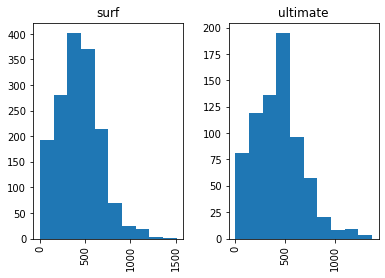

In [36]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

data_count.duration.hist(by=data_count['plan'])

In [37]:
data_count.groupby(['plan'])['duration'].agg(['mean','median']).reset_index()

,plan,mean,median
0,surf,427.120329,424.0
1,ultimate,428.071823,421.5


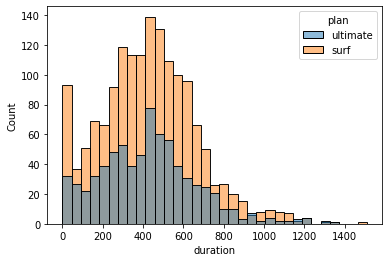

In [38]:
sns.histplot(data_count,x='duration',hue='plan');

In [39]:
# Calculate the mean and the variance of the monthly call duration

data_count.groupby(['plan'])['duration'].std()/data_count.groupby(['plan'])['duration'].mean()

plan
surf        0.551344
ultimate    0.565229
Name: duration, dtype: float64

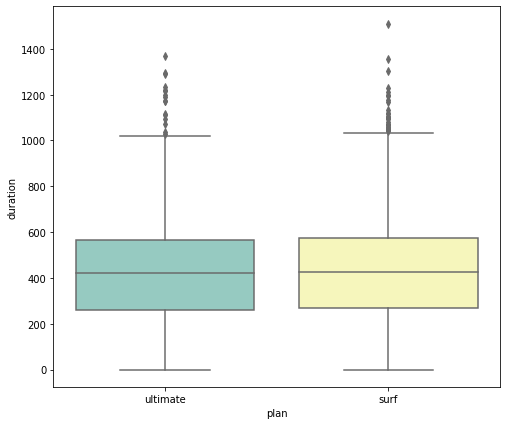

In [40]:
# Plot a boxplot to visualize the distribution of the monthly call duration

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.boxplot( x='plan',y="duration",
                 data=data_count, palette="Set3")


 judging by the table with the standard distribution and judging by the boxplots, there is not much difference in the behavior of clients in different plans. 

In [41]:
def distribution(parameter):
    
    
    
    
    
    if data_count[parameter].mean() > data_count[parameter].median():
        print('The data is skewed to the rihgt') 
    else:
        print('The data is skewed to the left')
    print('---------------------------------------')
    print('Statistics on: {}'.format(parameter))
    print(data_count[parameter].describe())
    
    
    
    print('---------------------------------------')
    print('The boxplot of: {}'.format(parameter))
    print('The histogram of: {}'.format(parameter))
    fig, ax = plt.subplots(figsize=(8,7))
    sns.histplot(data=data_count,bins=100,x=parameter,hue='plan')
    plt.show()
    ax = sns.boxplot( x='plan',y=parameter,
                     data=data_count, palette="Set3")
    print(plt.show())
    print('---------------------------------------')
    print('The cv calculation of:{}'.format(parameter))
    print(data_count.groupby(['plan'])[parameter].std()/data_count.groupby(['plan'])[parameter].mean())

The data is skewed to the rihgt
---------------------------------------
Statistics on: duration
count    2303.000000
mean      427.419453
std       237.490294
min         0.000000
25%       262.500000
50%       424.000000
75%       571.500000
max      1510.000000
Name: duration, dtype: float64
---------------------------------------
The boxplot of: duration
The histogram of: duration


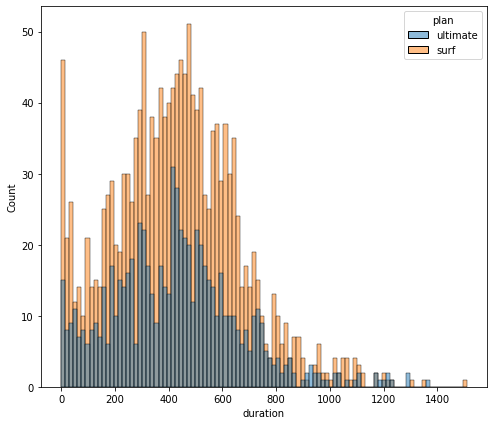

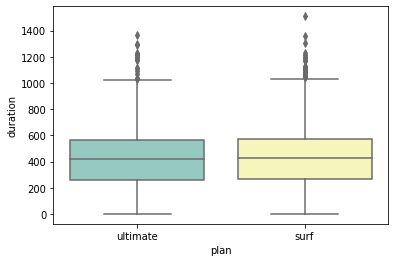

None
---------------------------------------
The cv calculation of:duration
plan
surf        0.551344
ultimate    0.565229
Name: duration, dtype: float64


In [42]:
distribution('duration')

### Messages

The data is skewed to the rihgt
---------------------------------------
Statistics on: message_count
count    2303.000000
mean       33.022579
std        34.065907
min         0.000000
25%         3.000000
50%        25.000000
75%        51.000000
max       266.000000
Name: message_count, dtype: float64
---------------------------------------
The boxplot of: message_count
The histogram of: message_count


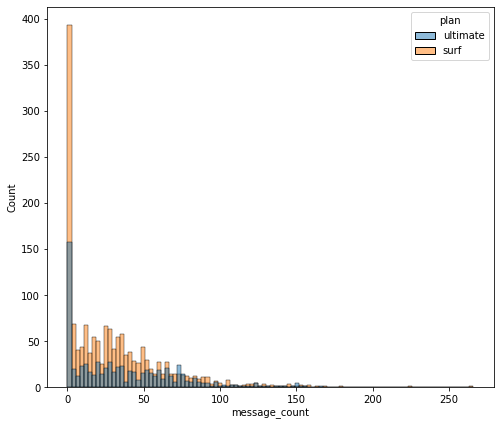

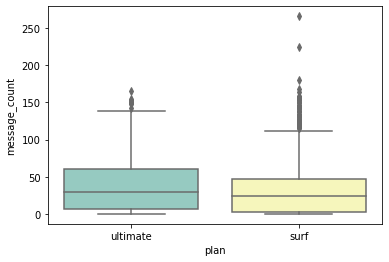

None
---------------------------------------
The cv calculation of:message_count
plan
surf        1.081070
ultimate    0.931412
Name: message_count, dtype: float64


In [43]:
distribution('message_count')

***Histogram***
- a lot of peaple do not sand sms (we see big massive of data on 0)

***Boxplot***
- a lot of outliers in the 'Surf' plan, these people would be better off and more profitable to switch to another plan

### Internet

The data is skewed to the left
---------------------------------------
Statistics on: gb_used
count    2303.000000
mean       16.797221
std         7.857946
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64
---------------------------------------
The boxplot of: gb_used
The histogram of: gb_used


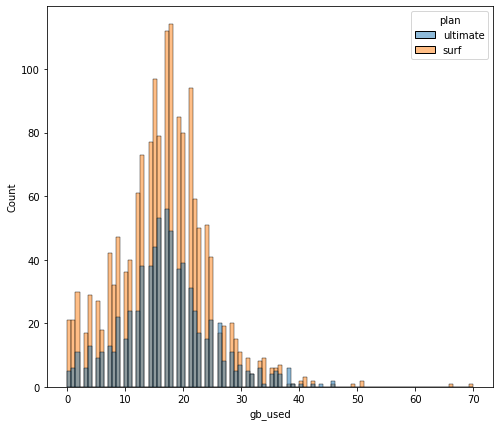

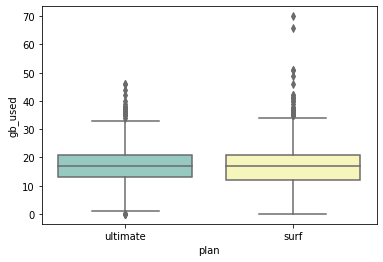

None
---------------------------------------
The cv calculation of:gb_used
plan
surf        0.475663
ultimate    0.450624
Name: gb_used, dtype: float64


In [44]:
distribution('gb_used')

***Histogram***
- normal distribution, suggesting that customer behaviour is almost indistinguishable.

***Boxplot***
- proves this version, with quite a few outliers, which tells us that both plans are quite profitable for the company. but perhaps the marketing plan needs to increase this plan for customers and add more internet. 

## Revenue

The data is skewed to the left
---------------------------------------
Statistics on: revenue
count    2303.000000
mean       64.245410
std        46.579107
min        20.000000
25%        23.390000
50%        70.000000
75%        70.000000
max       590.370000
Name: revenue, dtype: float64
---------------------------------------
The boxplot of: revenue
The histogram of: revenue


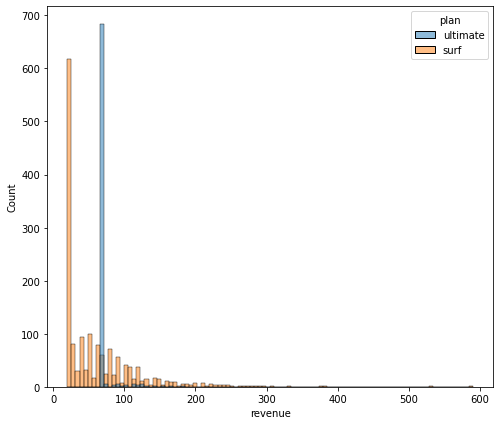

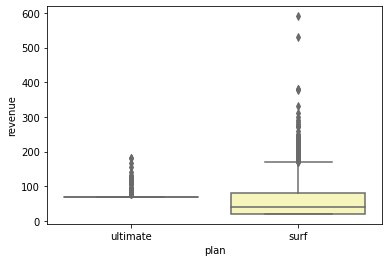

None
---------------------------------------
The cv calculation of:revenue
plan
surf        0.913919
ultimate    0.157188
Name: revenue, dtype: float64


In [45]:
distribution('revenue')

***Histogram***
- Most clients stay within their plan boundaries, i.e. they pay exactly what the plan describes ($20 and $70), and it is difficult to understand the behaviour of other 'ultimate' clients 

***Boxplot***
- in the Ultimate plan there is a very small distribution of clients, there are outliers, but not many
- in the "surf" plan, the distribution is close to normal, with many outliers, indicating that this plan is more profitable for the company. 

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

In [46]:
data_count.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,call_count,message_count,internet_count,mb_used,gb_used,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2050-12-31,12.0,124.0,16.0,11.0,5.0,1901.47,2.0,70.00
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,8.0,182.0,27.0,30.0,25.0,6919.15,7.0,20.00
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,9.0,315.0,49.0,44.0,53.0,13314.82,14.0,20.00
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,10.0,393.0,65.0,53.0,56.0,22330.49,22.0,90.09
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,11.0,426.0,64.0,36.0,51.0,18504.30,19.0,60.00


In [47]:
revenue = data_count[['city','plan','revenue']]
revenue.head()

,city,plan,revenue
0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70.00
1,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
2,"Seattle-Tacoma-Bellevue, WA MSA",surf,20.00
3,"Seattle-Tacoma-Bellevue, WA MSA",surf,90.09
4,"Seattle-Tacoma-Bellevue, WA MSA",surf,60.00


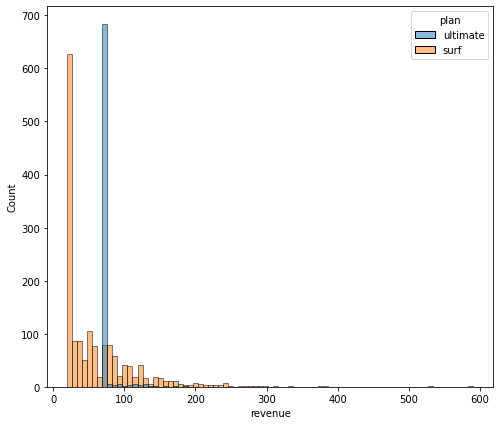

In [48]:
# Test the hypotheses

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.histplot(revenue, x="revenue", hue="plan")

***formulate our hypotheses***

 **Ho - Average of revenue of ultimate clients equal to average of revenue of surf clients.
   
   **H1 -  Average of revenue of ultimate clients not equal to average of revenue of surf clients.
   

In [49]:
surf = data_count.query('plan=="surf"')
ultimate = data_count.query('plan=="ultimate"')

In [50]:
sample1 = surf['revenue']
sample2 = ultimate['revenue']

In [51]:
print(len(sample1))
print(len(sample2))

1579
724


In [52]:
sample2.sample(500)

907     70.0
1167    70.0
910     70.0
52      70.0
1265    70.0
        ... 
248     70.0
255     70.0
976     70.0
144     70.0
787     70.0
Name: revenue, Length: 500, dtype: float64

In [53]:
stats.ttest_ind(sample1, sample2,nan_policy='omit')

Ttest_indResult(statistic=-5.657735755192741, pvalue=1.7244233141242384e-08)

In [54]:
p_value=stats.ttest_ind(sample1, sample2,nan_policy='omit').pvalue
p_value

1.7244233141242384e-08

In [55]:

alpha=0.05
if p_value<alpha:
    print('Reject H0: average of sample 1 is not equal to average of sample 2')
else:
    print( "Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 \
  and sample 2 are not the same")

Reject H0: average of sample 1 is not equal to average of sample 2


Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.

***formulate our hypotheses***

 **Ho - Average of revenue of clients from the NY-NJ region is equal to average of revenue of clients of other regions.
   
   **H1 - Average of revenue of clients from the NY-NJ region is not equal to average of revenue of clients of other regions.
   

In [56]:
data_count['city'].describe()

count                                          2303
unique                                           73
top       New York-Newark-Jersey City, NY-NJ-PA MSA
freq                                            378
Name: city, dtype: object

In [57]:
# Test the hypotheses

NY_NJ = data_count[data_count['city'].str.contains("NY")]
all_cities = data_count[~ data_count['city'].str.contains("NY")]
print(NY_NJ.head())
all_cities.head()

    user_id first_name last_name  age  \
56     1014    Edmundo     Simon   61   
57     1014    Edmundo     Simon   61   
75     1022         Bo      Snow   73   
76     1022         Bo      Snow   73   
77     1022         Bo      Snow   73   

                                         city   reg_date  plan churn_date  \
56  New York-Newark-Jersey City, NY-NJ-PA MSA 2018-11-25  surf 2050-12-31   
57  New York-Newark-Jersey City, NY-NJ-PA MSA 2018-11-25  surf 2050-12-31   
75  New York-Newark-Jersey City, NY-NJ-PA MSA 2018-04-20  surf 2018-09-07   
76  New York-Newark-Jersey City, NY-NJ-PA MSA 2018-04-20  surf 2018-09-07   
77  New York-Newark-Jersey City, NY-NJ-PA MSA 2018-04-20  surf 2018-09-07   

    month  duration  call_count  message_count  internet_count   mb_used  \
56   11.0     163.0        28.0            9.0             1.0   1175.59   
57   12.0    1114.0       150.0           64.0            19.0   7792.41   
75    5.0     302.0        39.0            0.0            14.0

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,duration,call_count,message_count,internet_count,mb_used,gb_used,revenue
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2050-12-31,12.0,124.0,16.0,11.0,5.0,1901.47,2.0,70.00
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,8.0,182.0,27.0,30.0,25.0,6919.15,7.0,20.00
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,9.0,315.0,49.0,44.0,53.0,13314.82,14.0,20.00
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,10.0,393.0,65.0,53.0,56.0,22330.49,22.0,90.09
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2050-12-31,11.0,426.0,64.0,36.0,51.0,18504.30,19.0,60.00


In [58]:
sample1 = NY_NJ['revenue']
sample2 = all_cities['revenue']

In [59]:
print(len(sample1))
print(len(sample2))

407
1896


In [60]:
sample2.sample(500)

2080     60.00
1341     20.27
257      70.00
1487     40.00
1886     70.00
         ...  
1437    121.02
1281    120.00
693      40.84
1535     90.00
2264     20.00
Name: revenue, Length: 500, dtype: float64

In [61]:
stats.ttest_ind(sample1, sample2, nan_policy='omit')

Ttest_indResult(statistic=-1.5844212825597008, pvalue=0.11323529806572001)

In [62]:
p_value=p_value.astype(int)
alpha=0.05
if p_value<alpha:
    print('Reject H0: average of sample 1 is not equal to average of sample 2')
else:
    print( "Fail to Reject H0: We don't have enough evidence to say that averages of sample 1 \
  and sample 2 are not the same")

Reject H0: average of sample 1 is not equal to average of sample 2


## General conclusion

References:

1) The "surf" plan brings in more revenue than the "ultimate" plan, but it might be worth changing the plans, as we see relatively few calls and texts, but quite a lot of internet use. it might be worth reviewing the plans. 

2) We have seen that customer behaviour in the New York/New Jersey region is different from other regions. It might be worth introducing a special tariff plan for this region.
As for the operations we performed on the data, we encountered missing values and handled them this way. In addition, the data type for date_time was changed where necessary. As required by the company, we rounded up each call made as well as monthly internet usage. We calculated the income for each user depending on the plan they were using, and based on the income table we created, histograms and bщчplots were able to analyse the mean values, variations and standard distribution. We then tested two hypotheses and found that the behaviour of customers with different tariff plans was not the same. We also found that the behaviour of customers in the New York New Jersey region is different from the behaviour of customers in other regions. This gives us the right to advise the company management to investigate this region separately and possibly offer a different tariff plan for it. 